## What's Yulu all about?

Yulu is India’s leading micro-mobility service provider, which offers unique vehicles for the daily commute. Starting off as a mission to eliminate traffic congestion in India, Yulu provides the safest commute solution through a user-friendly mobile app to enable shared, solo and sustainable commuting.

Yulu zones are located at all the appropriate locations (including metro stations, bus stands, office spaces, residential areas, corporate offices, etc) to make those first and last miles smooth, affordable, and convenient!

*Yulu has recently suffered considerable dips in its revenues*. They have contracted a consulting company to understand the factors on which the demand for these shared electric cycles depends. Specifically, **they want to understand the factors affecting the demand for these shared electric cycles** in the Indian market.

### Definition of problem 

- We intend to understand what factors affect the demand of electric cycles to cater to the problem of revenue dips.


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Setting 95% CI for this analysis
alpha = 0.05

In [3]:
data_link = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/428/original/bike_sharing.csv?1642089089"

df = pd.read_csv('data/yulu_analysis.csv', date_parser=["datetime"], infer_datetime_format=True)
# df.to_csv('data/yulu_analysis.csv',index=False)
# df.to_csv('data/walmart_transactions.csv', index=False)
df['datetime'] = pd.to_datetime(df['datetime'])
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Data Dictionary
- datetime: datetime
- season: season (1: spring, 2: summer, 3: fall, 4: winter)
- holiday: whether day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
- weather:
1. Clear, Few clouds, partly cloudy, partly cloudy
2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp: temperature in Celsius
- atemp: feeling temperature in Celsius
- humidity: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- count: count of total rental bikes including both casual and registered

In [4]:
df['season_name'] = df['season'].map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}).astype('category')
df['weather_condition'] = df['weather'].map({1: 'Clear/Partially Cloudy', 2: 'Misty/Cloudy', 3: 'Snowy/Slightly Rainy', 4: 'Extremely Unfavourable Weather'}).astype('category')

In [5]:
df['hour'] = df.datetime.dt.hour
df['Time_of_day'] = df['hour'].apply(lambda x: 'Night' if (x<7) | (x>22) else ('Morning' if x<10 else ('Afternoon' if x<16 else 'Evening'))).astype('category')
df['date'] = df.datetime.dt.date

In [46]:
cat_cols = ['season', 'holiday', 'workingday', 'weather', 'season_name', 'weather_condition', 'hour', 'Time_of_day']
num_cols = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
target_cols = ['casual', 'registered', 'count']

In [7]:
#checking datatypes
df.dtypes

datetime             datetime64[ns]
season                        int64
holiday                       int64
workingday                    int64
weather                       int64
temp                        float64
atemp                       float64
humidity                      int64
windspeed                   float64
casual                        int64
registered                    int64
count                         int64
season_name                category
weather_condition          category
hour                          int64
date                         object
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   datetime           10886 non-null  datetime64[ns]
 1   season             10886 non-null  int64         
 2   holiday            10886 non-null  int64         
 3   workingday         10886 non-null  int64         
 4   weather            10886 non-null  int64         
 5   temp               10886 non-null  float64       
 6   atemp              10886 non-null  float64       
 7   humidity           10886 non-null  int64         
 8   windspeed          10886 non-null  float64       
 9   casual             10886 non-null  int64         
 10  registered         10886 non-null  int64         
 11  count              10886 non-null  int64         
 12  season_name        10886 non-null  category      
 13  weather_condition  10886 non-null  category      
 14  hour  

In [9]:
#number of unique values in our data
for i in df.columns:
  print(i,':',df[i].nunique())

datetime : 10886
season : 4
holiday : 2
workingday : 2
weather : 4
temp : 49
atemp : 60
humidity : 89
windspeed : 28
casual : 309
registered : 731
count : 822
season_name : 4
weather_condition : 4
hour : 24
date : 456


In [10]:
df['date'].min(), df['date'].max()

# the data range comprises of almost 2 years data while no. of days covered are 456 days

(datetime.date(2011, 1, 1), datetime.date(2012, 12, 19))

In [11]:
#checking null values in every column of our data
df.isnull().sum()/len(df)*100

# No missing values found

datetime             0.0
season               0.0
holiday              0.0
workingday           0.0
weather              0.0
temp                 0.0
atemp                0.0
humidity             0.0
windspeed            0.0
casual               0.0
registered           0.0
count                0.0
season_name          0.0
weather_condition    0.0
hour                 0.0
date                 0.0
dtype: float64

In [12]:
df[num_cols].describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


reject the null hypothesis that temp is normal with p-value as 0.0
Distribution Plot for column: temp



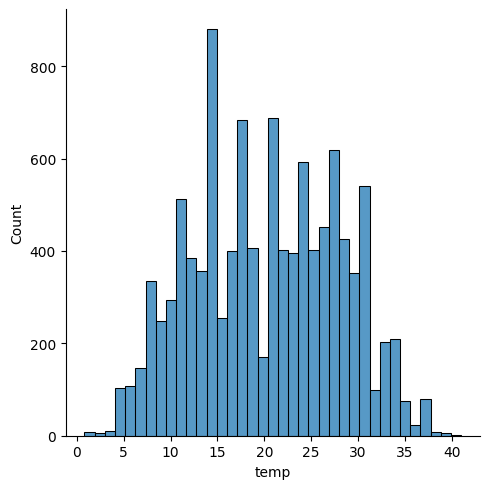

reject the null hypothesis that atemp is normal with p-value as 0.0
Distribution Plot for column: atemp



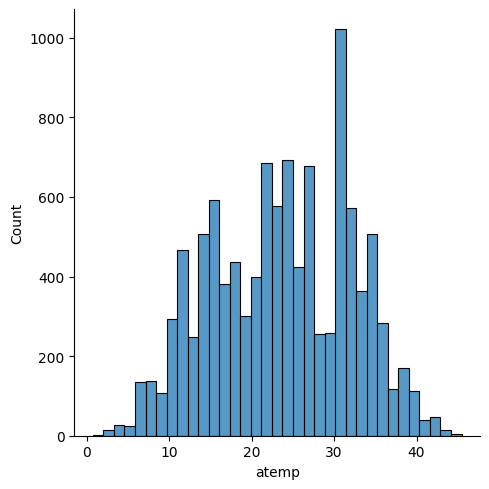

reject the null hypothesis that humidity is normal with p-value as 0.0
Distribution Plot for column: humidity



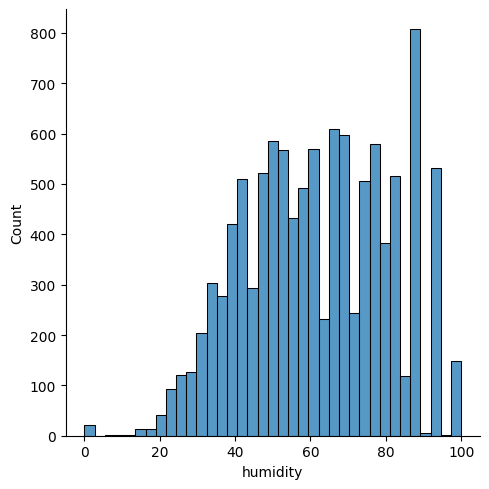

reject the null hypothesis that windspeed is normal with p-value as 0.0
Distribution Plot for column: windspeed



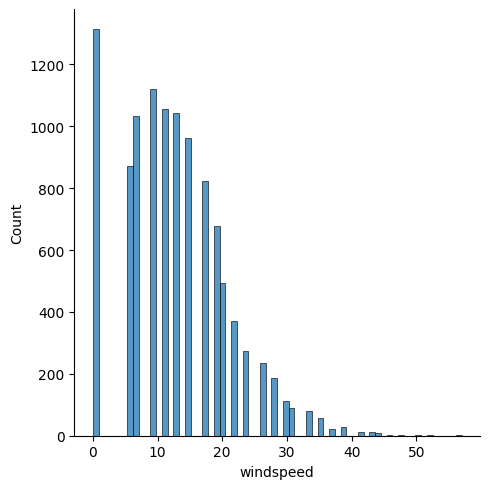

reject the null hypothesis that casual is normal with p-value as 0.0
Distribution Plot for column: casual



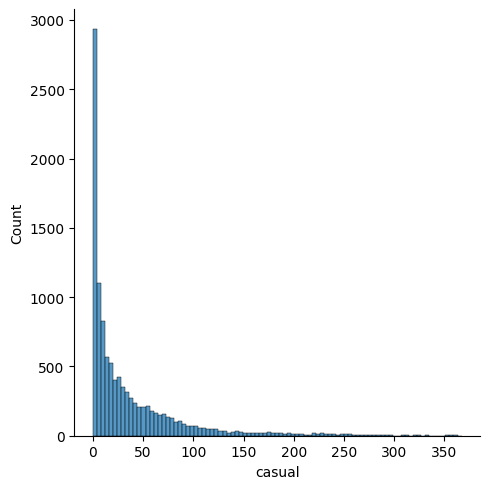

reject the null hypothesis that registered is normal with p-value as 0.0
Distribution Plot for column: registered



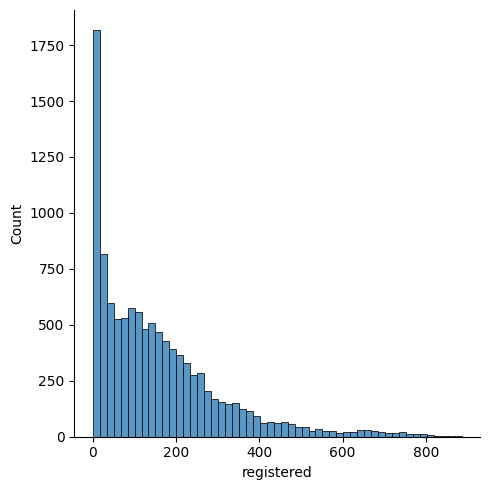

reject the null hypothesis that count is normal with p-value as 0.0
Distribution Plot for column: count



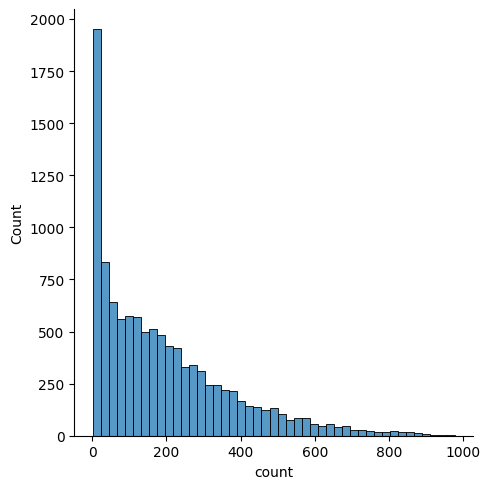

In [13]:
for i in num_cols:
    statistic, p = stats.kstest(df[i],stats.norm.cdf)
    if p< alpha:
        print(f"reject the null hypothesis that {i} is normal with p-value as {round(p, 3)}")
    else:
        print(f"Failed to reject the null hypothesis that {i} is normal with p-value as {round(p, 3)}")
    print(f"Distribution Plot for column: {i}\n")
    sns.displot(df[i])
    
    plt.show()

In [14]:
df.shape

(10886, 16)

In [15]:
#checking the occurences of each of the season
df['season'].value_counts(1)

# Occupation category: All Seasons are almost equally distributed across the dataset

4    0.251148
2    0.251056
3    0.251056
1    0.246739
Name: season, dtype: float64

In [16]:
#checking the occurences of each of the workingday
df['workingday'].value_counts(1)

# workingday category: 70% of the days are working across data

1    0.680875
0    0.319125
Name: workingday, dtype: float64

In [17]:
#checking the occurences of each of the workingday
df['weather_condition'].value_counts()

# workingday category: Extremely Unfavourable Weather conditions are the least populated data which is a very small sample to come up with any hypothesis at all.

# To get a much better understanding of the data, we should merge weather class 3 & 4 to just one class Rainy/Snowy to make reasonable sense of the data



Clear/Partially Cloudy            7192
Misty/Cloudy                      2834
Snowy/Slightly Rainy               859
Extremely Unfavourable Weather       1
Name: weather_condition, dtype: int64

In [18]:
df['weather'].value_counts(1)

1    0.660665
2    0.260334
3    0.078909
4    0.000092
Name: weather, dtype: float64

In [19]:
df.loc[df['weather'] == 4, "weather"] = 3

In [20]:
# Simplifying the data here.
df['weather_condition'] = df['weather'].map({1: 'Clear/Partially Cloudy', 2: 'Misty/Cloudy', 3: 'Snowy/Rainy'}).astype('category')


In [21]:
df['weather_condition'].value_counts(1)

Clear/Partially Cloudy    0.660665
Misty/Cloudy              0.260334
Snowy/Rainy               0.079001
Name: weather_condition, dtype: float64

In [22]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'season_name', 'weather_condition', 'hour', 'date'],
      dtype='object')

#### Concepts Deployed:

- Bi-Variate Analysis
- 2-sample t-test: testing for difference across populations
- ANNOVA
- Chi-square

#### Bi-Variate Analysis

In [47]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'season_name', 'weather_condition', 'hour', 'date', 'Time_of_day'],
      dtype='object')

In [24]:
df.season.unique()

array([1, 2, 3, 4])

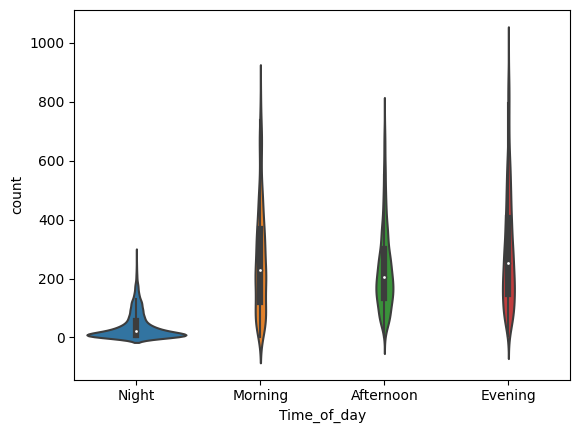

In [45]:
sns.violinplot(data=df, x='Time_of_day', y='count')
plt.show()

# A holiday doesn't seem to be creating any difference whatsoever in terms of product usage. 
# Although, its natural to think that during holidays people might tend to use more

# Hypothesis 2:
# H0: mu(t1) = mu(t2) = mu(t3) = mu(t4), User usage is same across time of day.
# HA: mu(t1) != mu(t2) != mu(t3) != mu(t4), User usage is not the same across time of day.


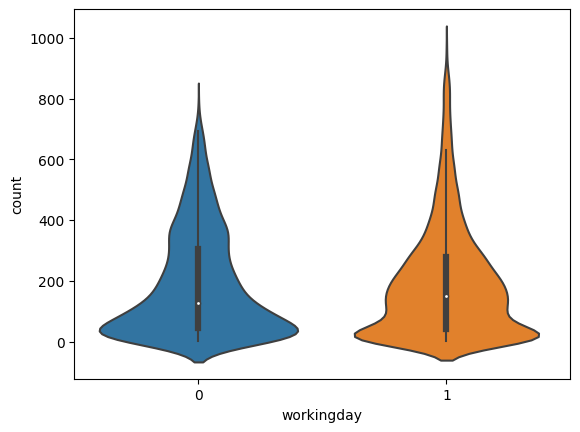

In [39]:
sns.violinplot(data=df, x='workingday', y='count')
plt.show()

# A working day v/s non-working day doesn't seem to be creating much difference whatsoever in terms of product usage. 
# We will verify this via hypothesis tests

# Hypothesis 4:
# H0: mu(w) = mu(nw), All day user usage is same irrespective workingday.
# HA: mu(w) != mu(nw), working day Usage > Non-working day Usage.

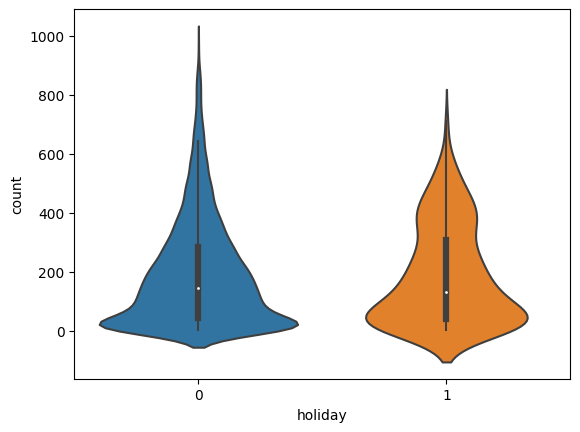

In [38]:
sns.violinplot(data=df, x='holiday', y='count')
plt.show()

# A holiday doesn't seem to be creating any difference whatsoever in terms of product usage. 
# Although, its natural to think that during holidays people might tend to use more

# Hypothesis 3:
# H0: mu(h) = mu(nh), All day user usage is same irrespective holiday.
# HA: mu(h) > mu(nh), Holiday Usage > Non-Holiday Usage.

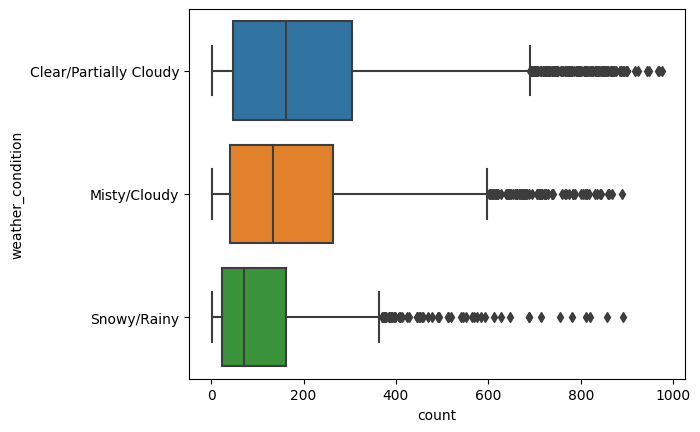

In [25]:
sns.boxplot(data=df, y='weather_condition', x='count')
plt.show()

# the median differences across weather conditions shows that Clear/Partially Cloudy/Misty/Cloudy are weather conditions 
# wherein people tend to use electric cycles more as compared to Snowy/Rainy weather conditions for obvious reasons that they can't utilize yulu's service if the weather conditions can't support them.

# Hypothesis 1:
# H0: mu(w1) = mu(w2) = mu(w3), All weather user usage is same.
# HA: mu(w1) != mu(w2) != mu(w3), All weather user usage is not same.

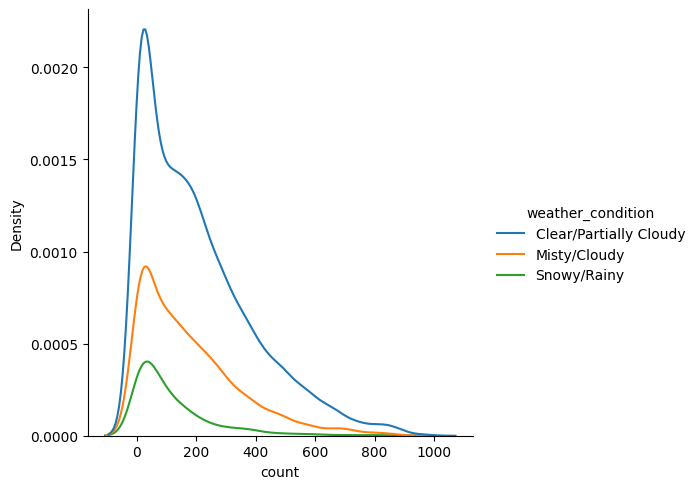

In [26]:
sns.displot(data=df, hue='weather_condition', x='count', kind ='kde')
plt.show()

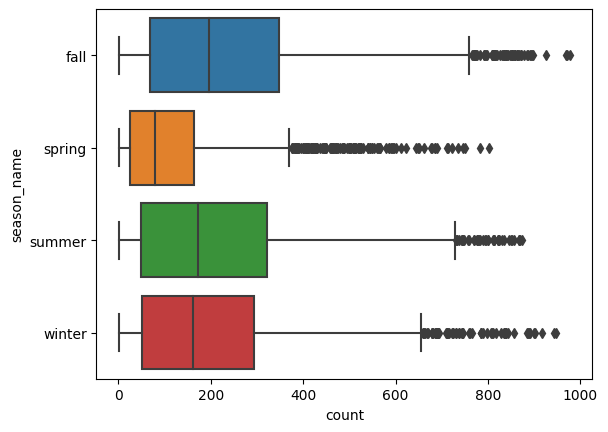

In [27]:
sns.boxplot(data=df, y='season_name', x='count')
plt.show()

# Spring seems to be that one season which has held back on customers

# Hypothesis 2:
# H0: mu(s1) = mu(s2) = mu(s3) = mu(s4), All season user usage is same.
# HA: mu(s1) != mu(s2) != mu(s3) != mu(s4), All season user usage is not same.

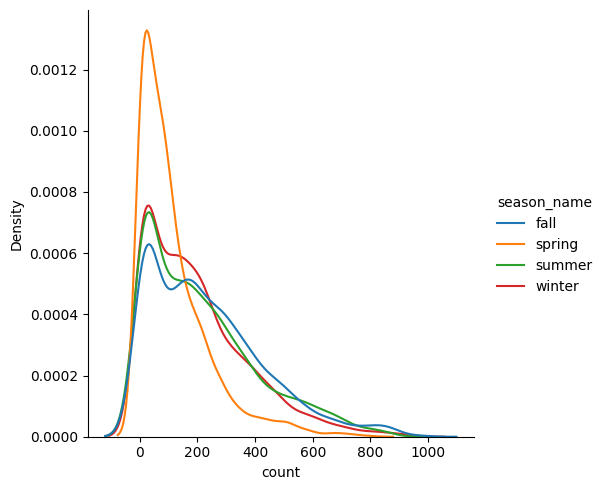

In [28]:
sns.displot(data=df, hue='season_name', x='count', kind ='kde')
plt.show()

In [ ]:
import scipy.stats as stats
def cramers_v(x, y): # After Applying Cramers Correction
    """ Calculate Cramers V Corrected statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
   
    confusion_matrix = pd.crosstab(x,y)

    if confusion_matrix.shape[0]==2:
        correct=False
    else:
        correct=True

    chi2 = stats.chi2_contingency(confusion_matrix, correction = correct)[0] 
    # Pearson's chi-squared statistic value used here

    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    #print(phi2corr)
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    result = np.sqrt( phi2corr / min( (kcorr-1), (rcorr-1) ) )
    return round(result, 6)

#### Cramér's V Theory

https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

- Cramér's V (sometimes referred to as Cramér's phi and denoted as φc) is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic and was published by Harald Cramér in 1946

In [ ]:
### Chisquare Test Hypothesis

- H0: the two samples are independent of each other.
- H1: there is a dependency between the samples.

Also, we will be using Cramér's V Corrected Value as a measure to quantify the association among various categorical variables only.

In [54]:
pd.crosstab(index=df['weather_condition'], columns=df['season_name'], values=df['count'], aggfunc=np.sum)

season_name,fall,spring,summer,winter
weather_condition,,,,
Clear/Partially Cloudy,470116,223009,426350,356588
Misty/Cloudy,139386,76406,134177,157191
Snowy/Rainy,31160,13083,27755,30255


<AxesSubplot: >

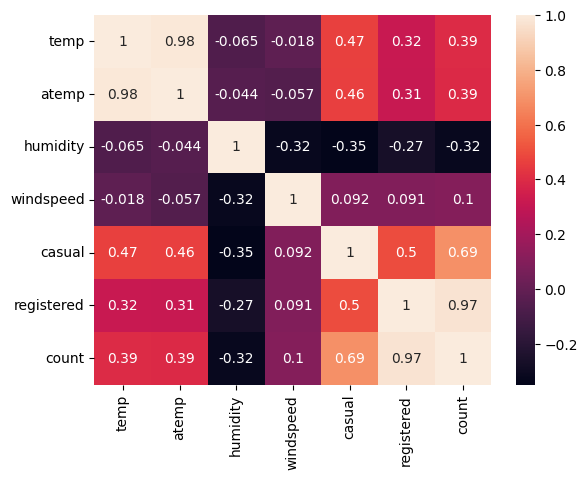

In [37]:
sns.heatmap(df[num_cols].corr(), annot=True)

In [29]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,season_name,weather_condition,hour,date
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,spring,Clear/Partially Cloudy,0,2011-01-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,spring,Clear/Partially Cloudy,1,2011-01-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,spring,Clear/Partially Cloudy,2,2011-01-01
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,spring,Clear/Partially Cloudy,3,2011-01-01
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,spring,Clear/Partially Cloudy,4,2011-01-01


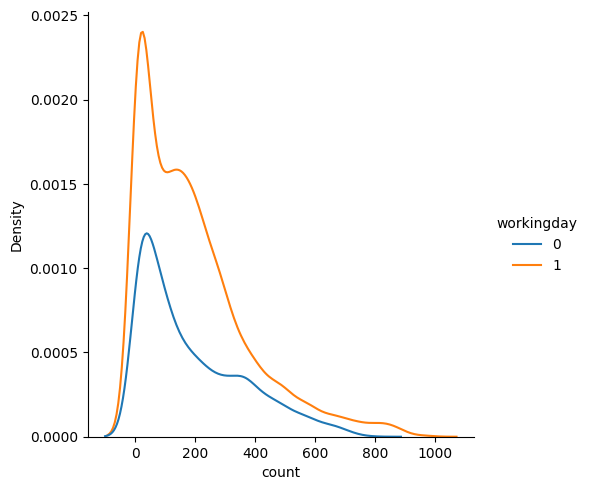

In [30]:
sns.displot(data=df, x='count', hue='workingday', kind='kde')

In [31]:
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,season_name,weather_condition,hour,date
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,spring,Clear/Partially Cloudy,0,2011-01-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,spring,Clear/Partially Cloudy,1,2011-01-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,spring,Clear/Partially Cloudy,2,2011-01-01
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,spring,Clear/Partially Cloudy,3,2011-01-01
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,spring,Clear/Partially Cloudy,4,2011-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,winter,Clear/Partially Cloudy,19,2012-12-19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,winter,Clear/Partially Cloudy,20,2012-12-19
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,winter,Clear/Partially Cloudy,21,2012-12-19
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,winter,Clear/Partially Cloudy,22,2012-12-19
